<a href="https://colab.research.google.com/gist/gretahartm/b3c4968779c9e09ea9bb8ff04fa750b7/10notebooksb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Track videos with your trained network

GPU access

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Cloning into 'unetTracker'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1022 (delta 233), reused 353 (delta 204), pack-reused 621 (from 1)
Receiving objects: 100% (1022/1022), 127.56 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (623/623), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/ssfolder"
if os.path.exists(fn):
  print("We can access the ssfolder directory.")
else:
  raise IOError("Problem accessing the ssfolder directory.")

Mounted at /content/drive
We can access the ssfolder directory.


In [3]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/ssfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/ssfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'simonebiles_tracker', 'normalization_values': {'means': [0.1952759027481079, 0.15899455547332764, 0.13951754570007324], 'stds': [0.16387943923473358, 0.16304421424865723, 0.16733983159065247]}, 'object_colors': [(240.0, 248.0, 255.0), (250.0, 235.0, 215.0), (0.0, 255.0, 255.0), (127.0, 255.0, 212.0), (240.0, 255.0, 255.0), (245.0, 245.0, 220.0), (255.0, 228.0, 196.0), (0.0, 0.0, 0.0), (255.0, 235.0, 205.0), (0.0, 0.0, 255.0)], 'objects': ['head', 'right

In [4]:
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.utils import extract_object_position_from_video

In [5]:
dataset = UNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinate_dir=project.coordinate_dir)


In [6]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


In [7]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)
project.load_model(model)
_ = model.eval()

/content/drive/My Drive/ssfolder/unetTracker/trackingProject.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_fn))


In [8]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))

Loading valTransform from /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/augmentation/valTransform


In [9]:
valTransform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.1952759027481079, 0.15899455547332764, 0.13951754570007324], std=[0.16387943923473358, 0.16304421424865723, 0.16733983159065247], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [10]:
video_fn = '/content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.mp4'
if os.path.exists(video_fn):
  print("We can access the video file.")
else:
  raise IOError("Problem accessing {}".format(video_fn))

We can access the video file.


In [11]:
df = extract_object_position_from_video(project=project,transform=valTransform,
                                        model=model,device=device,
                                        video_fn=video_fn,blobMinArea=10,
                                        plotData=False,
                                        #nFrames=10000,
                                        #startFrameIndex=15*60*3,
                                        BGR2RGBTransformation=False)

Number of frames in /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.mp4: 3327
Processing 3327 frames from index 0


100%|██████████| 3327/3327 [04:08<00:00, 13.39it/s]


In [12]:
tracking_fn = (os.path.splitext(video_fn)[0]) + ".csv"
print("Saving ",tracking_fn)
df.to_csv(tracking_fn,index=False)

Saving  /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.csv


In [13]:
df = pd.read_csv(tracking_fn)
df

,head_x,head_y,head_p,right knee_x,right knee_y,right knee_p,left knee_x,left knee_y,left knee_p,right foot_x,...,left hand_p,right shoulder_x,right shoulder_y,right shoulder_p,left shoulder_x,left shoulder_y,left shoulder_p,behind_x,behind_y,behind_p
0,136.019897,108.042488,0.589741,132.669205,170.195465,0.841789,119.378815,176.361099,0.926836,125.119034,...,0.921218,NaN,NaN,0.005126,NaN,NaN,0.042701,122.762383,151.240921,0.981254
1,133.283218,108.649460,0.662160,131.464005,170.471725,0.970615,129.133087,170.564560,0.965348,125.256577,...,0.987355,NaN,NaN,0.002006,NaN,NaN,0.005792,121.981491,151.622299,0.950224
2,133.184158,108.545113,0.663699,131.464005,170.471725,0.970125,129.169830,170.563126,0.966344,125.194115,...,0.988674,NaN,NaN,0.002001,NaN,NaN,0.005769,121.960205,151.606247,0.951334
3,131.923981,109.831337,0.472340,130.459473,170.293396,0.974942,127.609161,170.028976,0.974997,124.557335,...,0.967090,NaN,NaN,0.049196,NaN,NaN,0.045728,120.715919,151.915680,0.865786
4,131.898575,109.856804,0.477298,130.459473,170.293396,0.974942,127.609161,170.028976,0.975031,124.557335,...,0.966767,NaN,NaN,0.049540,NaN,NaN,0.046492,120.727005,151.912125,0.865969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,248.528259,136.440186,0.999075,220.452621,148.866638,0.984335,242.638947,165.443665,0.988386,206.002274,...,0.001179,254.454132,97.330566,0.997576,236.929626,95.010635,0.996357,249.438904,132.606476,0.704849
3323,248.564941,136.407883,0.998986,220.455383,148.904221,0.982671,242.645920,165.444443,0.988105,205.979309,...,0.001119,254.437820,97.316910,0.997475,236.805649,95.009140,0.995084,249.412857,132.555267,0.715743
3324,247.631393,136.411880,0.997394,218.552338,149.484833,0.968756,241.163223,165.511246,0.996047,206.502548,...,0.037238,252.936569,97.687485,0.993370,237.160141,94.716164,0.815089,248.652771,132.522369,0.578368
3325,247.631393,136.411880,0.997421,218.555588,149.487488,0.968166,241.142288,165.462585,0.996078,206.550934,...,0.037316,252.913727,97.651833,0.993185,237.133057,94.727440,0.814424,248.645279,132.510544,0.574892


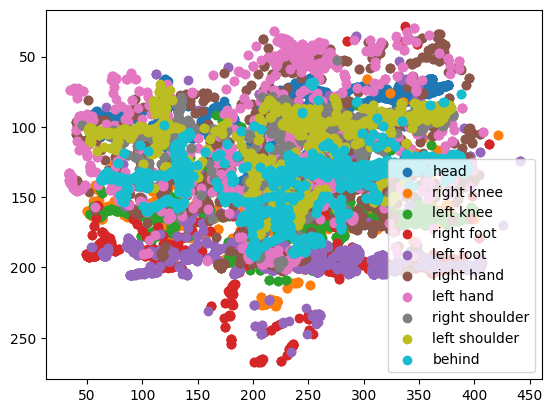

In [14]:
for obj in project.object_list:
    plt.scatter(df[f"{obj}_x"],df[f"{obj}_y"],label=obj)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.legend()

In [15]:
obj = project.object_list[0]
cName = f"{obj}_x"
print("Number of Nan:", np.sum(np.isnan(df[cName])))
print("percentage of Nan: {:.2f}%".format(np.sum(np.isnan(df[cName]))/len(df[cName])*100))

Number of Nan: 617
percentage of Nan: 18.55%


In [16]:
label_fn = (os.path.splitext(video_fn)[0]) + "_label.avi"
print(video_fn, tracking_fn,label_fn)

/content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.mp4 /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles.csv /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/videos/simonebiles_label.avi


In [17]:
from unetTracker.utils import label_video

In [18]:
label_video(project,video_fn,tracking_fn,label_fn)

Number of frames: 3327


100%|██████████| 3327/3327 [00:10<00:00, 324.78it/s]
